<a href="https://colab.research.google.com/github/Kritkikomo/HoursePricing-model/blob/main/Week4_Housepricemodel_175_chakrit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices - Advanced Regression Techniques competition
#### การบ้านสำหรับสำหรับสัปดาห์ที่ Machine Learning supervised คอร์ส The Data Master
###### เขียนโดย Chakrit Wanthanathanya ปรับปรุงล่าสุดเมื่อ 17/1/2023
###### โค้ดนี้ถูกสร้างเพื่อจำลองโมเดลทำนายราคาบ้านจากข้อมูลชุดด้านดังแสดงด้านล่าง
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/tutorials
###### และใช้โค้ดอ้างอิงจากแหล่งด้านล่าง
https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1

## ส่วนที่ 1 นำเข้า และ ทำความเข้าใจข้อมูล

In [ ]:
# อิมพอร์ทlibrary สำหรับการจำลอง
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing,model_selection,metrics
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from collections import OrderedDict
from sklearn.linear_model import ElasticNetCV,   LassoCV,  BayesianRidge, LassoLarsIC, LinearRegression,RidgeCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def outlier_treatment(datacolumn,num=2):
  sorted(datacolumn)
  Q1,Q3 = np.percentile(datacolumn , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (num * IQR) ##ใช้ 2 แทน ค่า 1.5 เนื่องจาก 1.5 มีการตัดข้อมูลเยอะไป
  upper_range = Q3 + (num * IQR)
  return lower_range,upper_range
def rmsle_cv(model,X,y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
# # ในกรณีใช้ drive ให้run ส่วนนี้
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# อิมพอร์ทไฟล์ที่เกี่ยวข้องในรูป dataframe
# หารันโค้ดให้เปลี่ยนpath สองบรรทัดล่าง
train_path = '/content/drive/MyDrive/Colab Notebooks/ML1/train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/ML1/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_ID = train_df['Id']
test_ID = test_df['Id']
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

In [ ]:
# print(train_df.info())
# print(test_df.info())
# print(train_df.describe())
# จะเห็นว่ายังมีบางคอลัมที่ยังมีค่า nan อยู่ ทำการ clean data เพื่อนำไปใช้งานต่อ

### พล็อตheat map เพื่อ ดูความสัมพันธ์

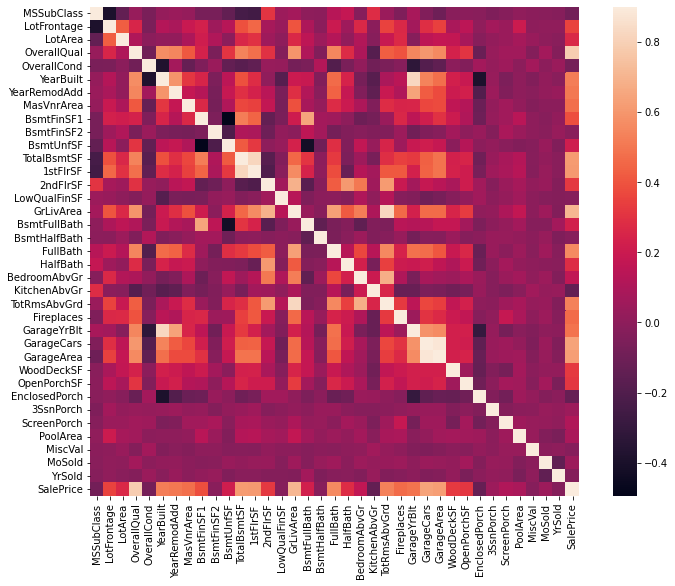

In [ ]:
num_col_list = train_df.columns[(train_df.dtypes == 'int64')|(train_df.dtypes == 'float64')].to_list()
obj_col_list = train_df.columns[(train_df.dtypes == 'object')].to_list()
col_name =train_df.columns.to_list()

# Visualise the data
corrmat = train_df[num_col_list].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()


### พล็อต ข้อมูลในรูป scatter plot เพื่อดูข้อมูลก่อนการclean

<ipython-input-124-f7acb19b39cd>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()
<ipython-input-124-f7acb19b39cd>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()
<ipython-input-124-f7acb19b39cd>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()
<ipytho

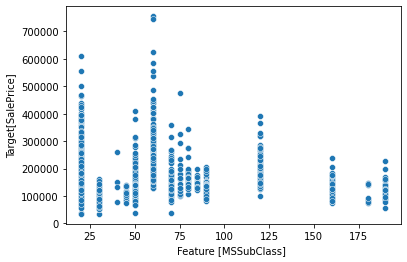

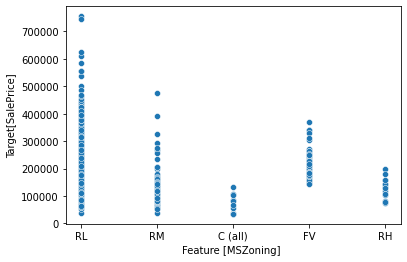

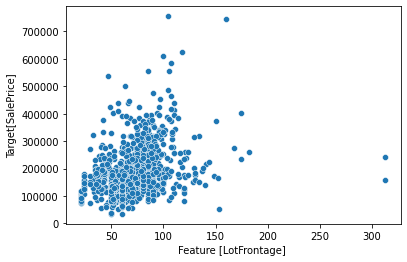

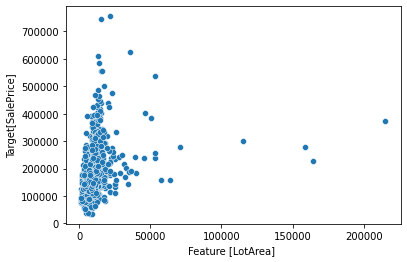

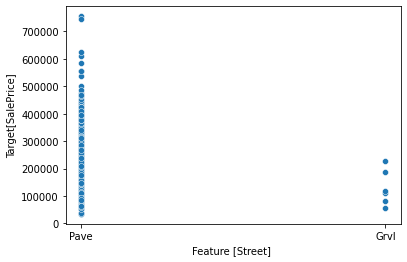

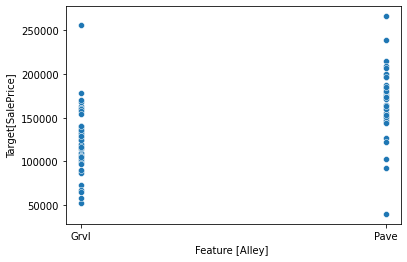

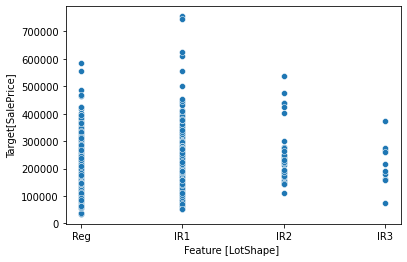

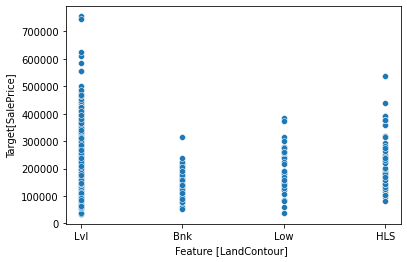

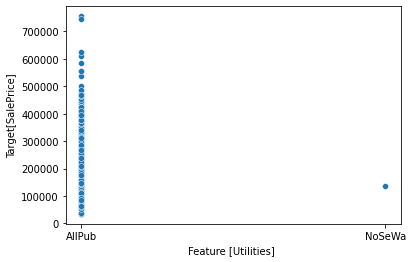

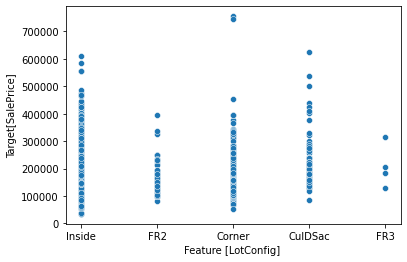

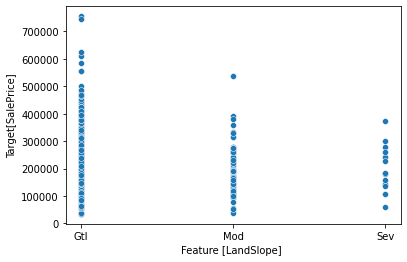

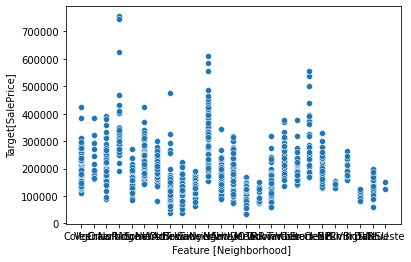

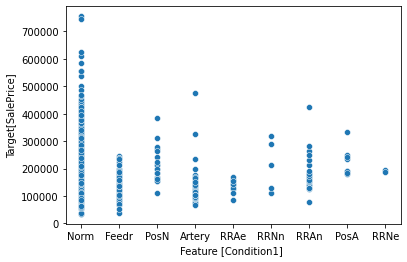

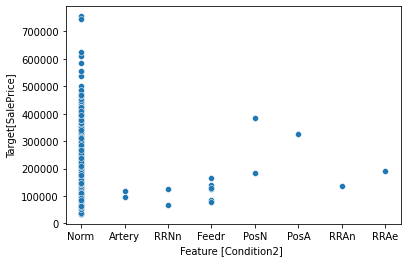

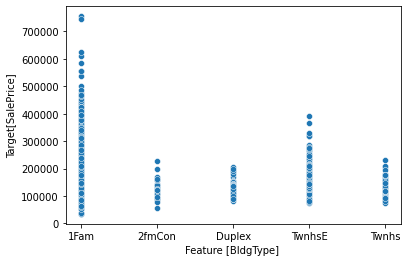

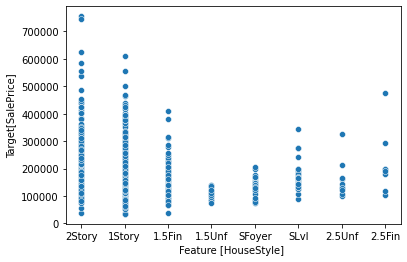

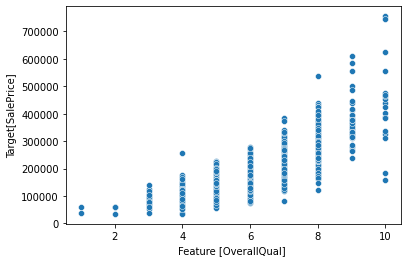

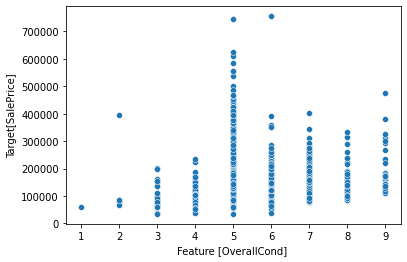

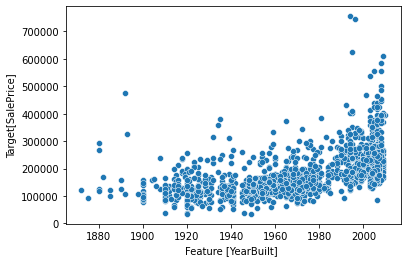

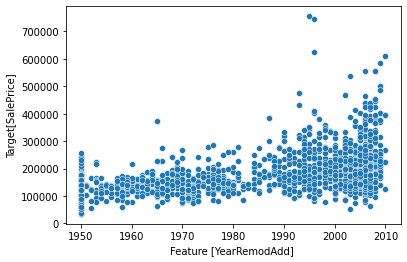

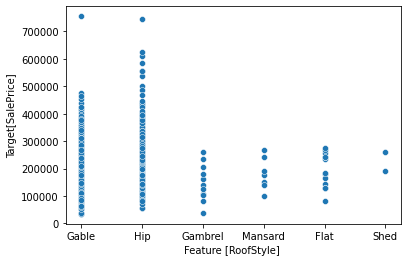

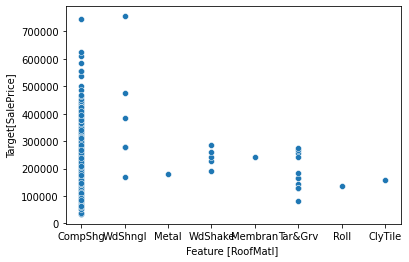

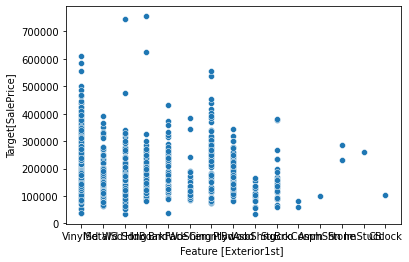

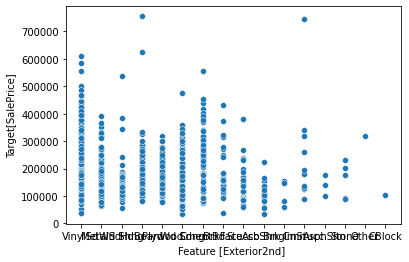

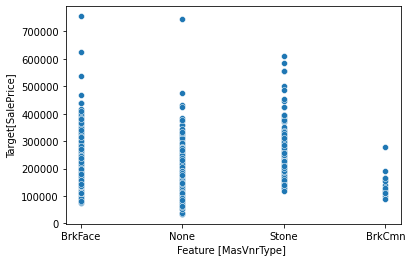

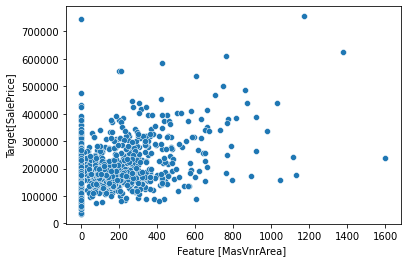

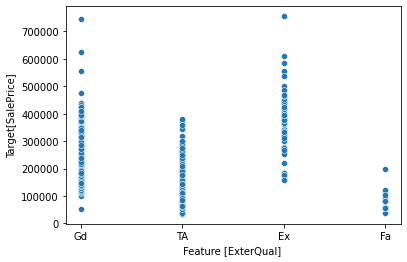

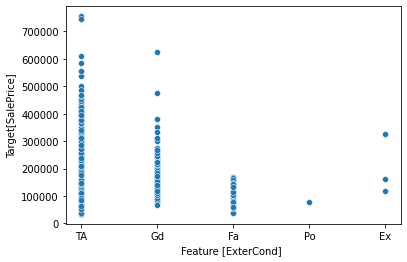

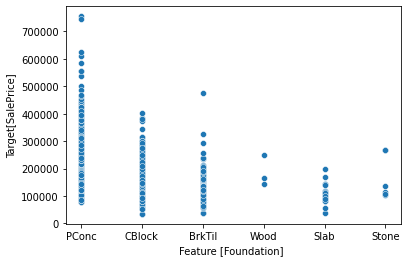

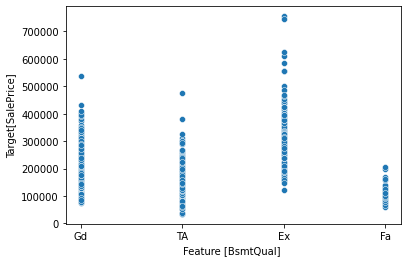

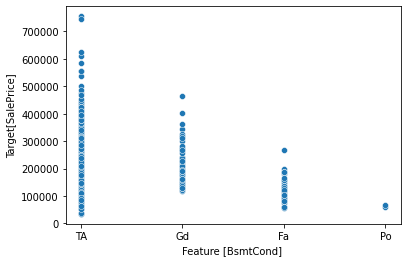

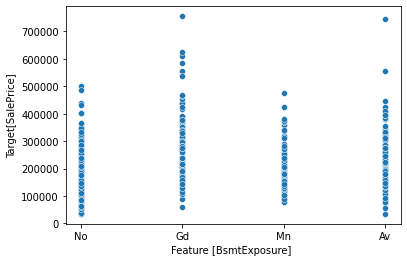

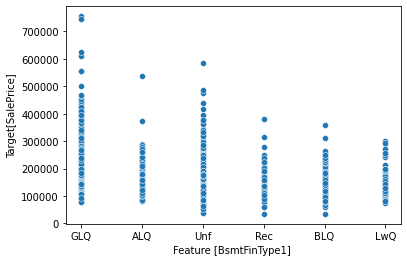

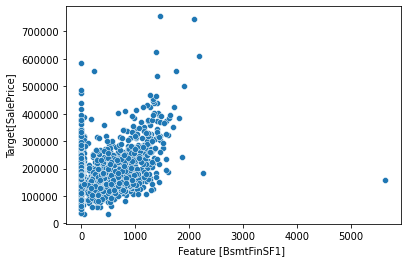

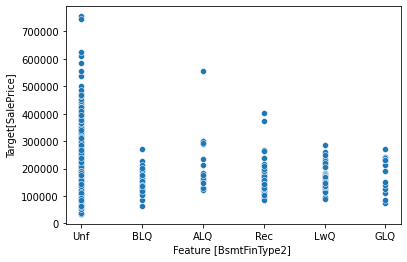

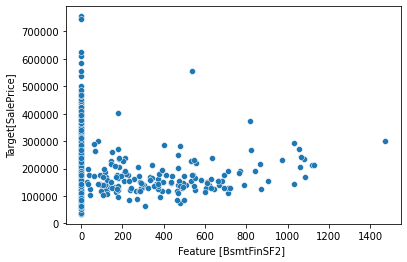

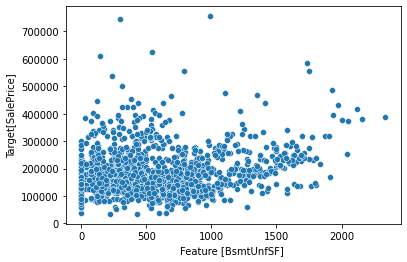

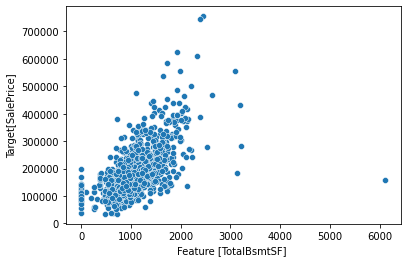

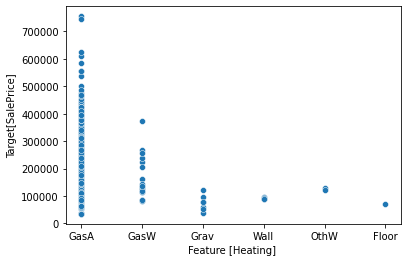

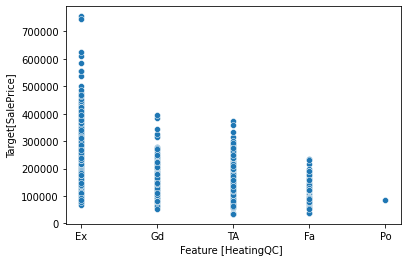

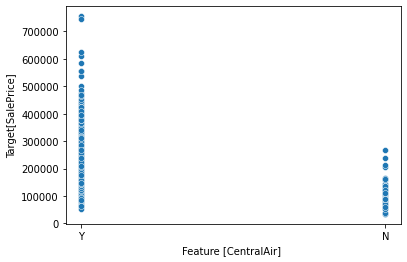

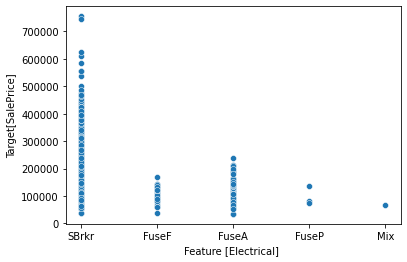

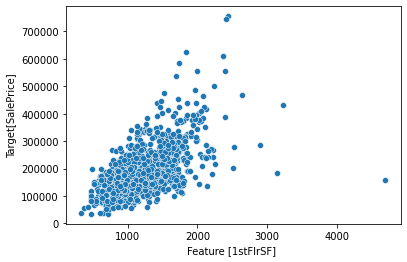

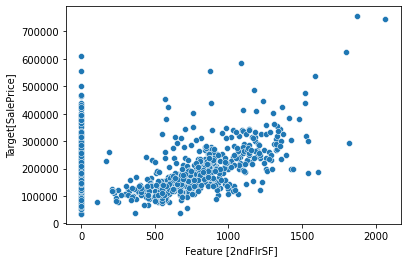

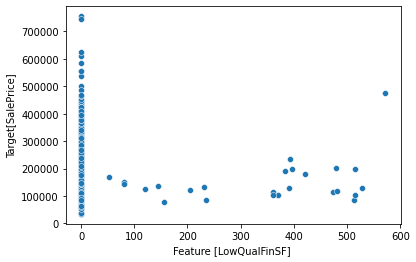

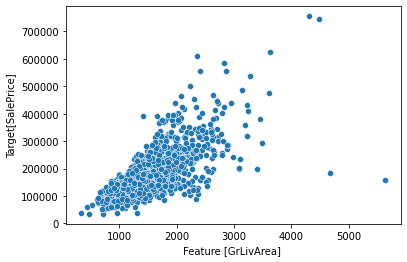

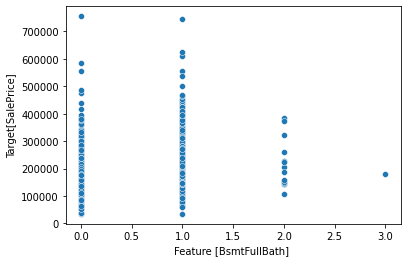

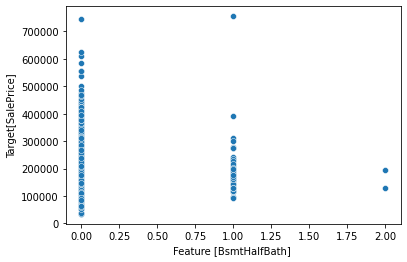

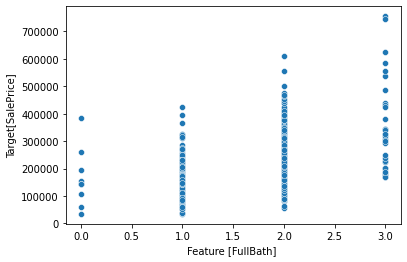

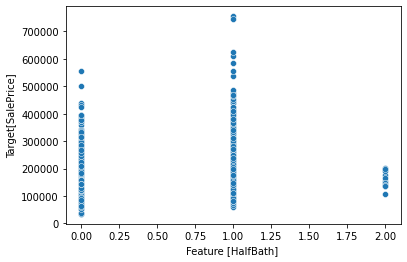

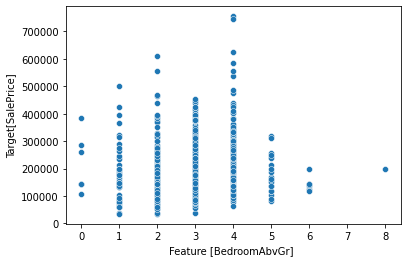

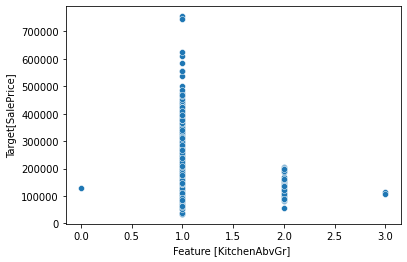

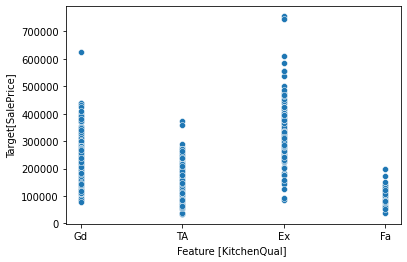

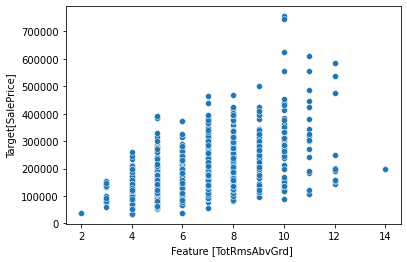

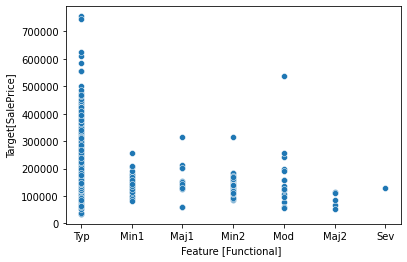

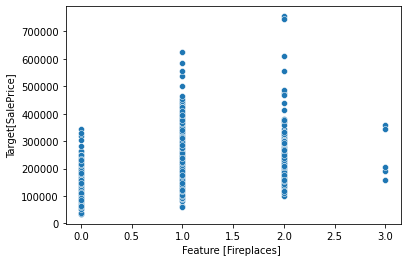

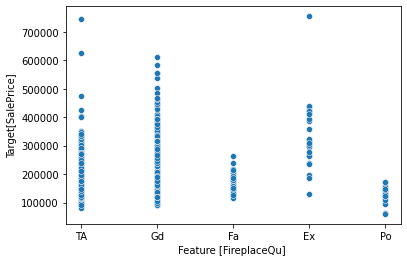

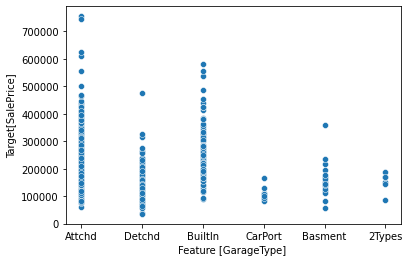

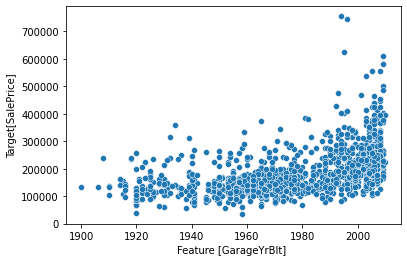

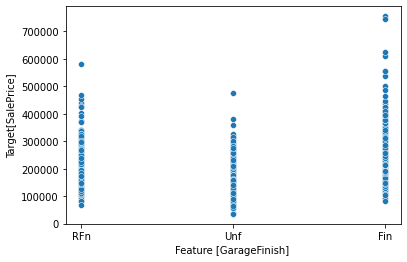

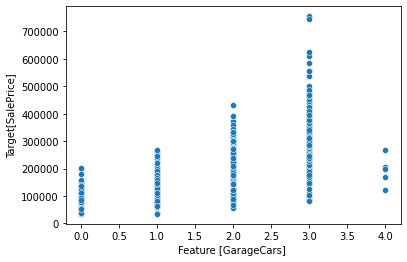

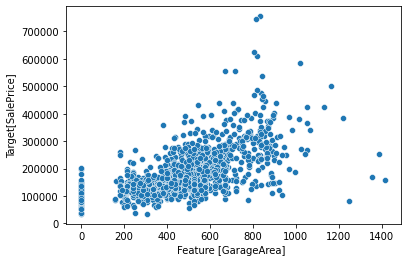

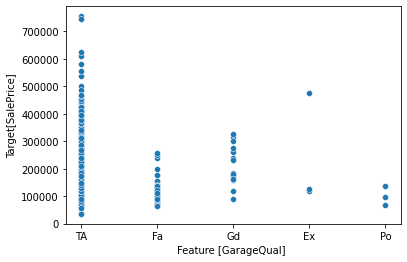

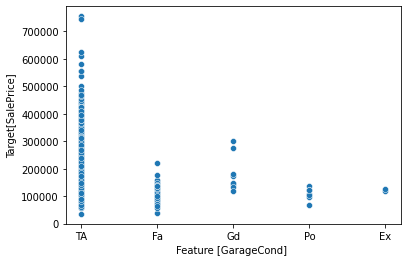

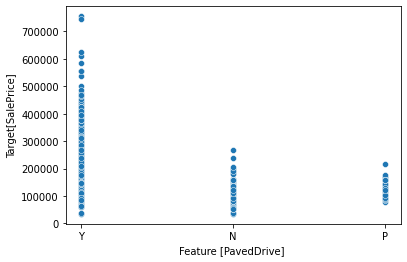

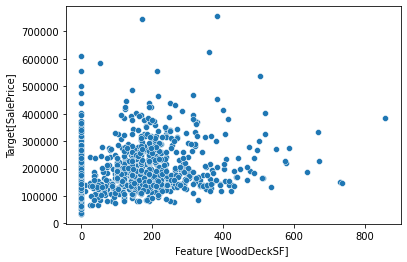

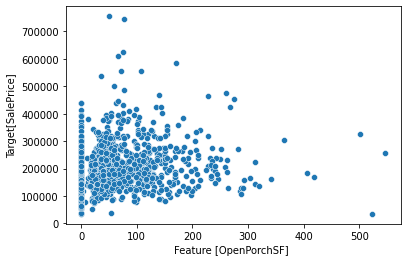

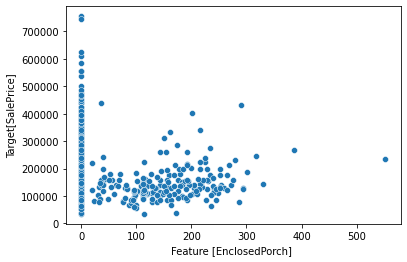

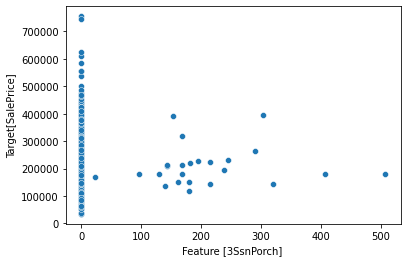

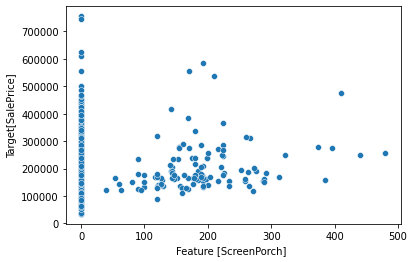

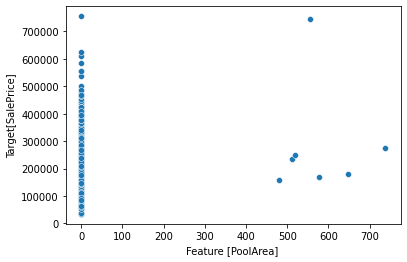

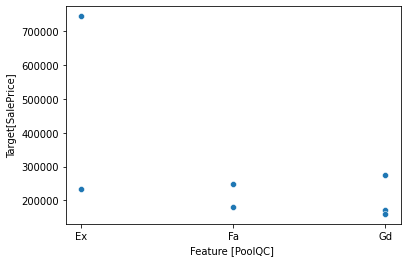

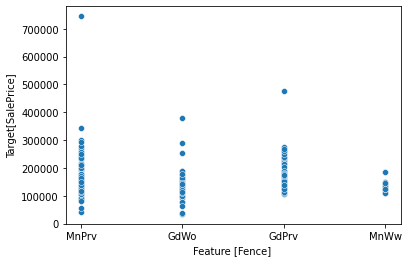

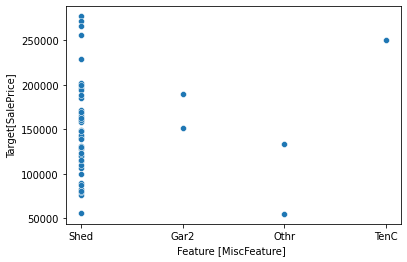

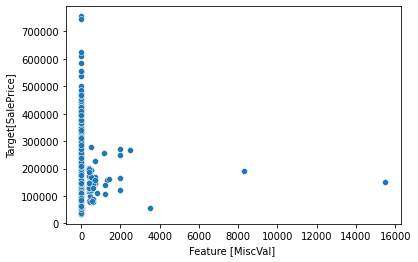

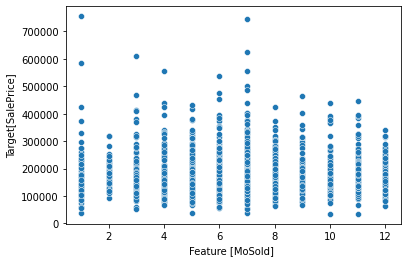

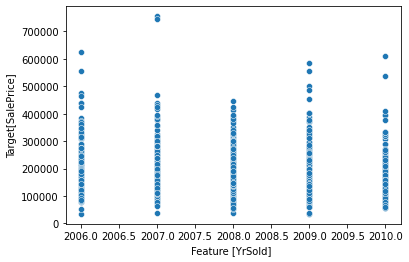

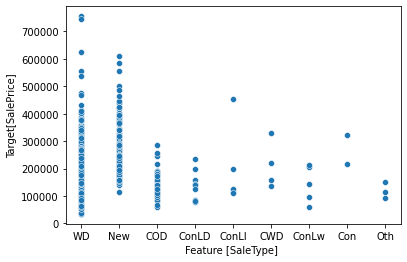

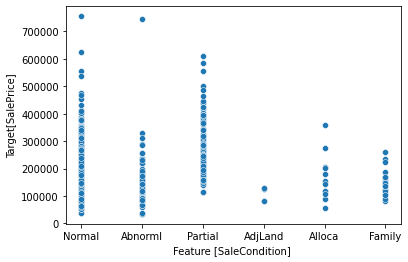

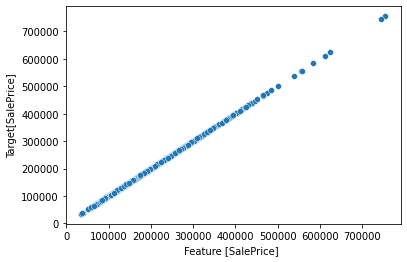

['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']


In [ ]:
cor_list = corrmat[abs(corrmat['SalePrice'])>=0.3]['SalePrice'].index.to_list()# กรองเฉพาะcolที่มีค่าสัมบูรณ์ของcorrelation มากกว่าหรือเท่ากับ 0.3 |cor|>=0.3
for i in col_name:
  fig,ax = plt.subplots()
  sns.scatterplot(x=i,y='SalePrice',data=train_df)
  ax.set_ylabel('Target[SalePrice]')
  ax.set_xlabel('Feature [' + str(i) + '] ')
plt.show()
print(cor_list)

In [ ]:
train_df.shape # จำนวนข้อมูลก่อนการ clean

(1460, 80)

# ส่วนที่ 2 จัดการข้อมูล
## ในส่วนนี้จะทำการ Clean และ Transform ข้อมูล เพื่อไปใช้ต่อ


### clean ในส่วนของข้อมูลที่เป็นรูปแบบ int และ float โดยใช้ เกณฑ์
####lower_range<ข้อมูลที่ต้องการ< upper_range
#### โดยที่
#####lower_range = Q1 - (num * IQR) 
#####upper_range = Q3 + (num * IQR)
##### โดย numจะกำหนดเป็น 2 (ผลมาจากการทดลอง) และทำการclean ด้วยตนเองต่อ

In [ ]:
### clean Outlier ในข้อมูล 
for i in cor_list:
  if i =='SalePrice':
    continue
  lowerbound,upperbound=outlier_treatment(train_df[i],num=2)
  train_df = train_df.drop(train_df[(train_df[i]<lowerbound) | (train_df[i]>upperbound)].index)
### Clean ข้อมูลโดยอ้างอิงจากกราฟด้านล่าง
train_df = train_df.drop(train_df[(train_df['SalePrice']>50000) & (train_df['LotFrontage']>100)].index)
train_df = train_df.drop(train_df[(train_df['SalePrice']>550000)].index)
train_df = train_df.drop(train_df[(train_df['LotArea']>26000)].index)
train_df = train_df.drop(train_df[(train_df['YearBuilt']<1900)& (train_df['SalePrice']>200000)].index)
train_df = train_df.drop(train_df[(train_df['MasVnrArea']>1400)].index)
train_df = train_df.drop(train_df[(train_df['BsmtFinSF2']>1400)].index)
train_df = train_df.drop(train_df[(train_df['MiscVal']>3000)].index)


### พล็อตดูผลลัพธ์หลังการ Clean

<ipython-input-127-c5d9a1b261c5>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()
<ipython-input-127-c5d9a1b261c5>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()
<ipython-input-127-c5d9a1b261c5>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()
<ipytho

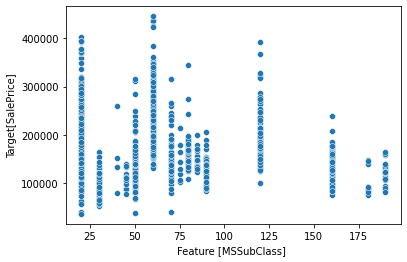

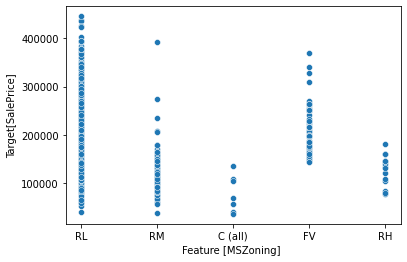

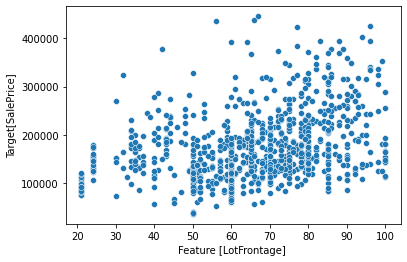

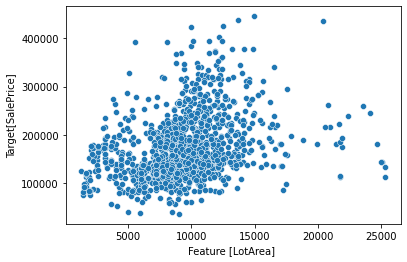

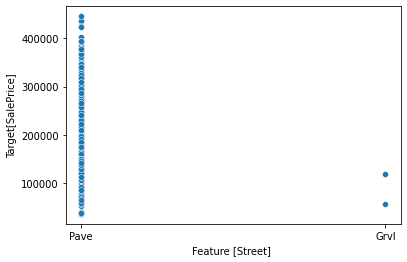

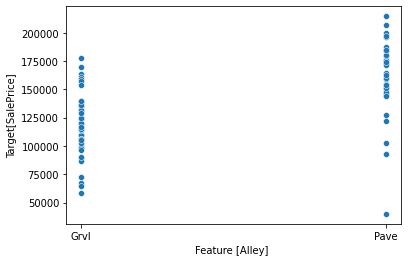

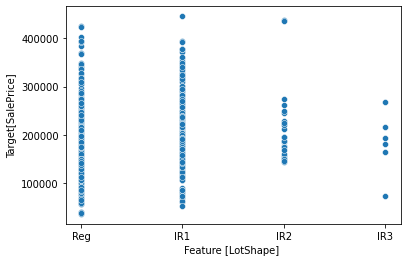

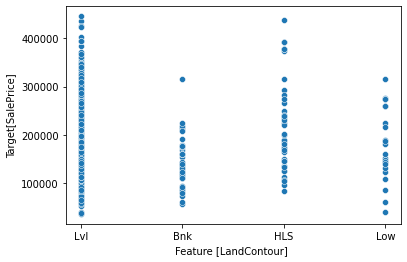

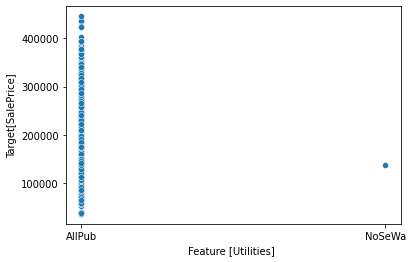

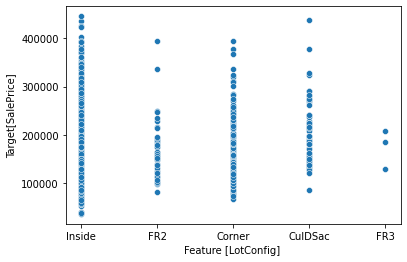

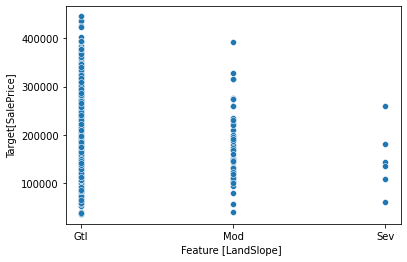

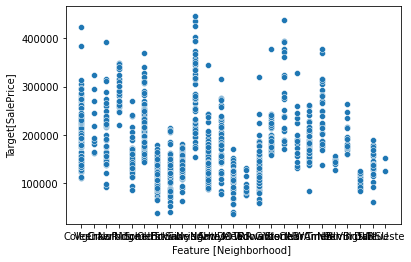

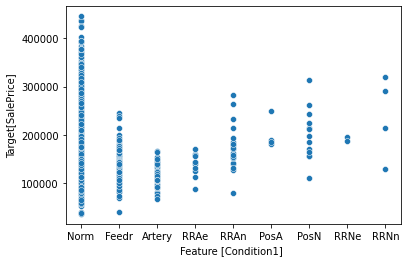

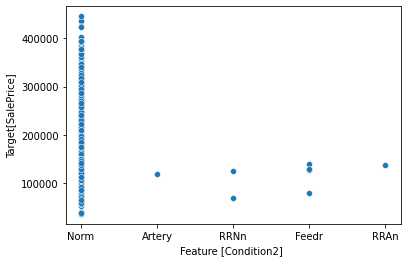

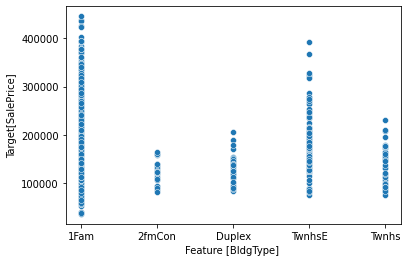

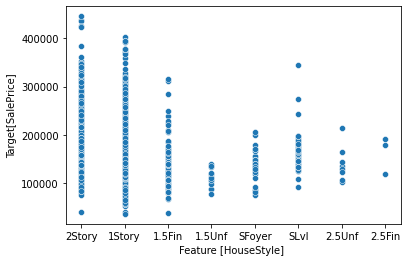

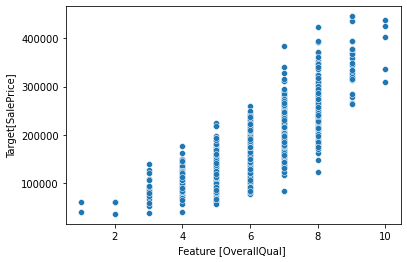

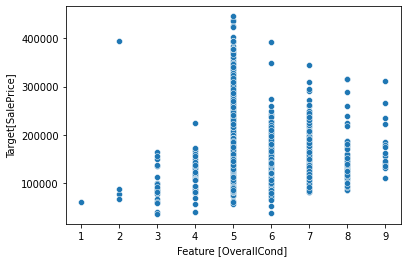

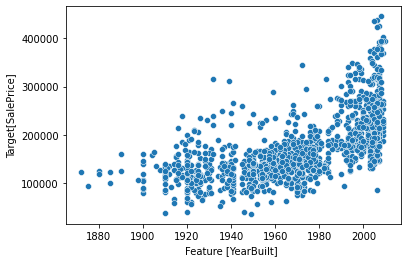

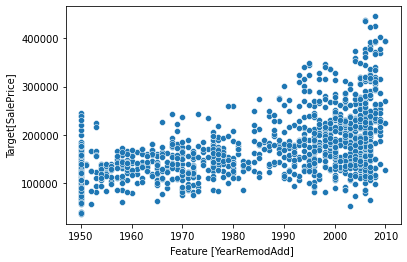

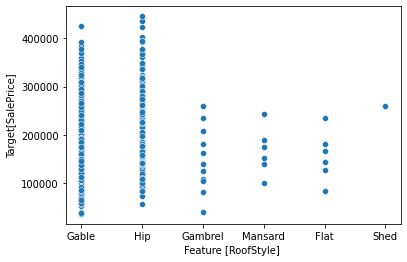

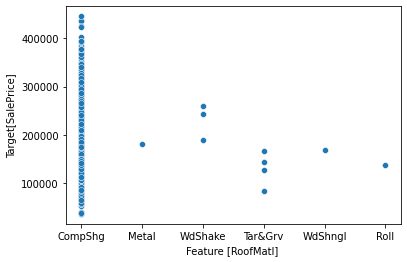

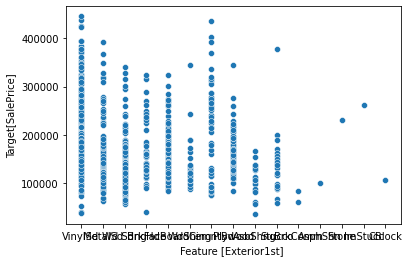

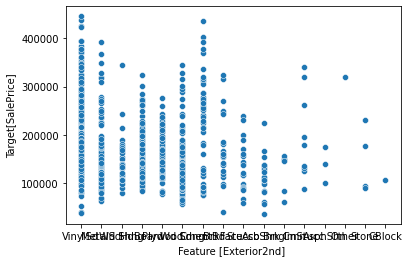

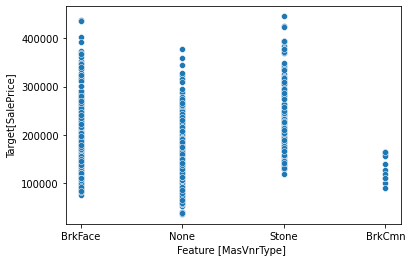

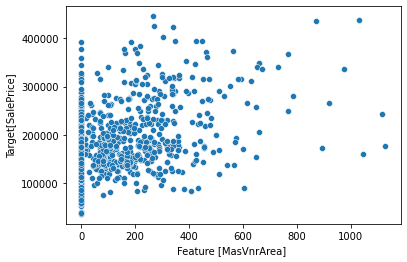

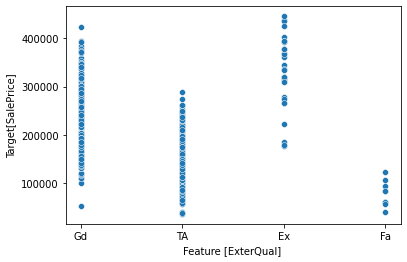

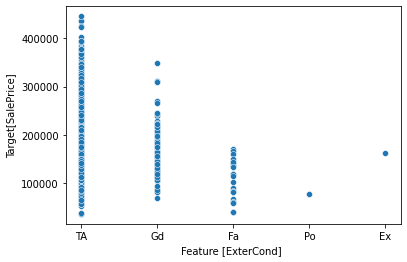

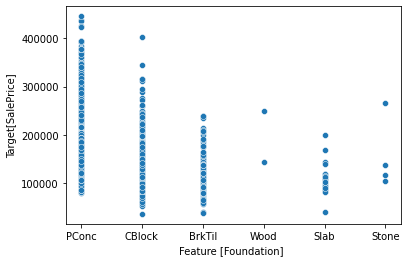

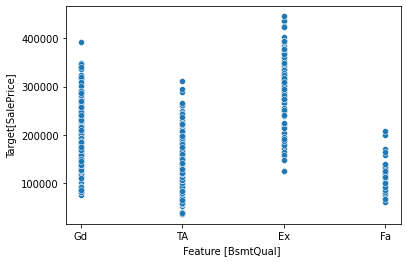

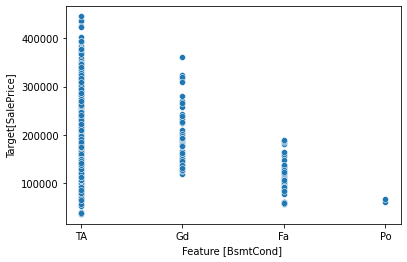

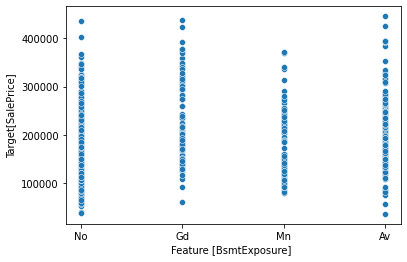

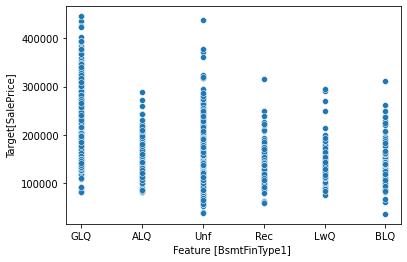

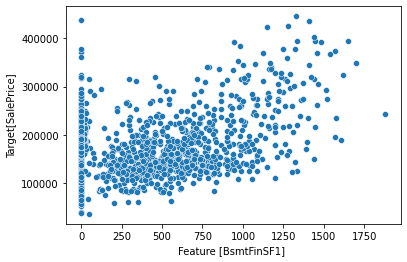

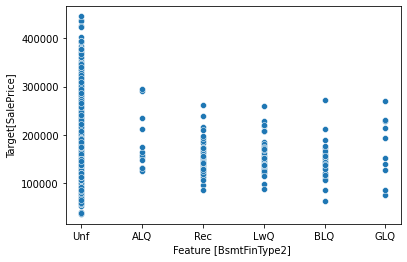

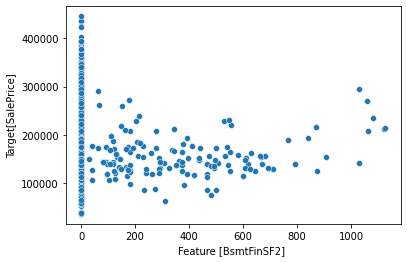

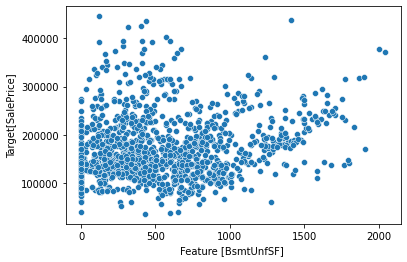

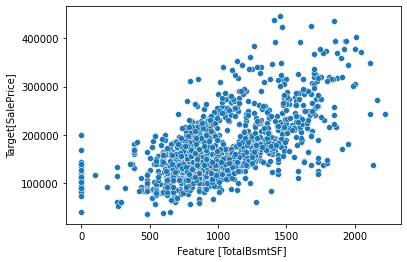

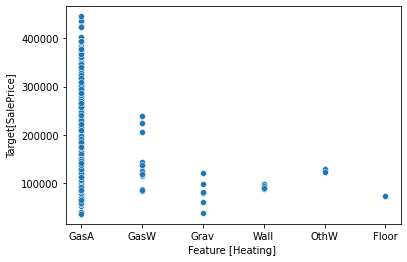

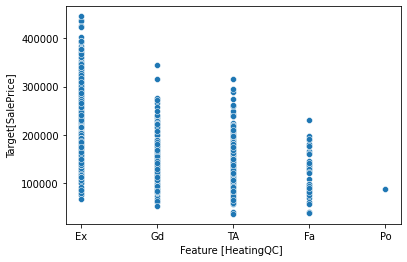

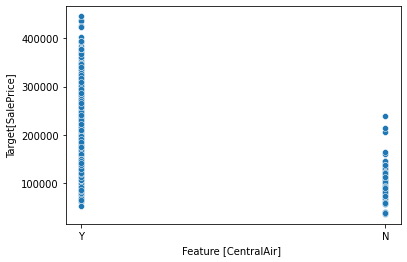

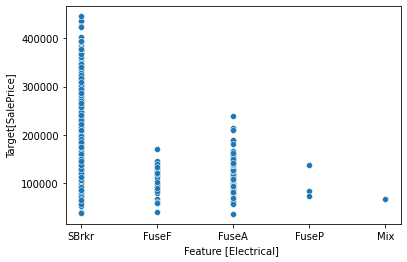

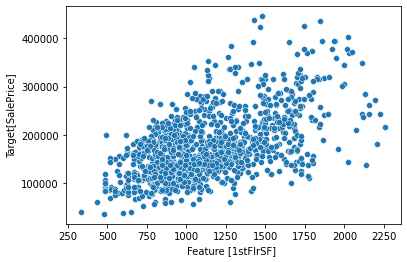

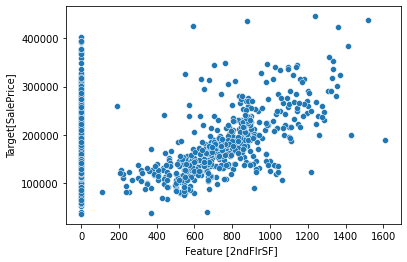

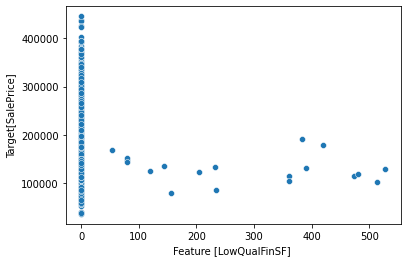

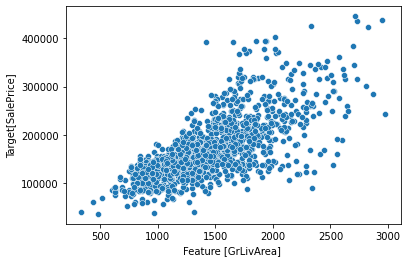

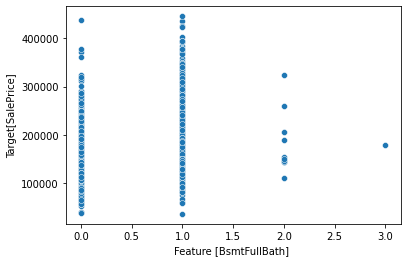

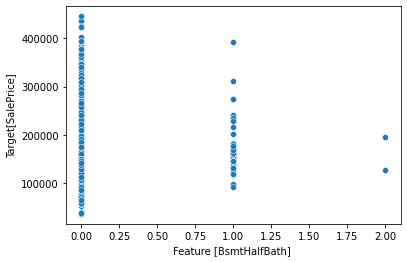

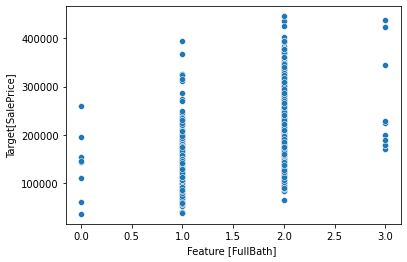

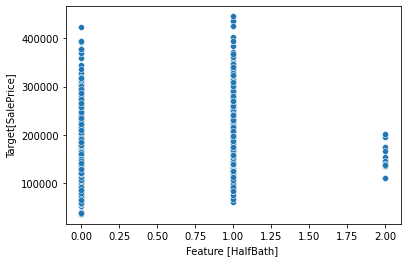

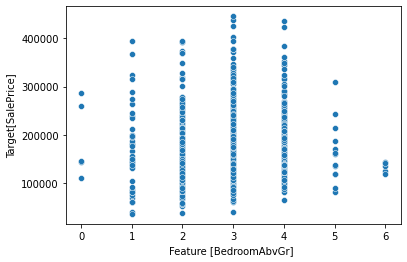

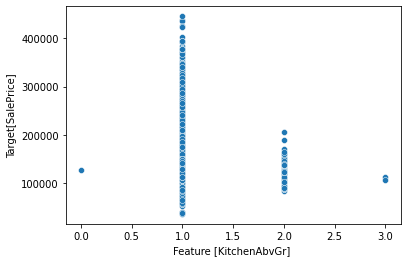

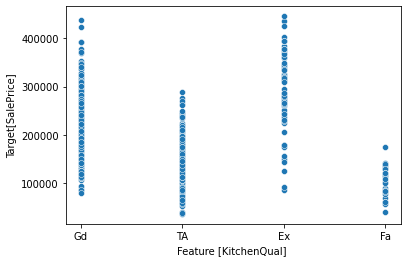

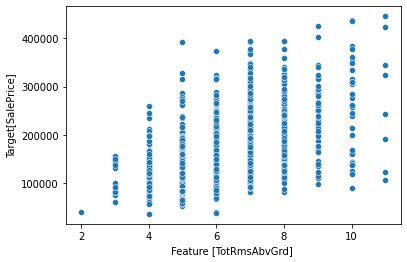

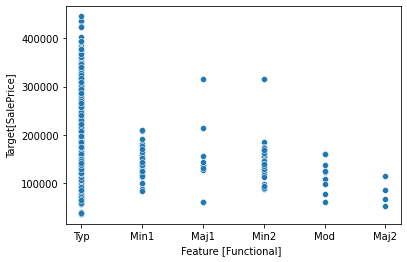

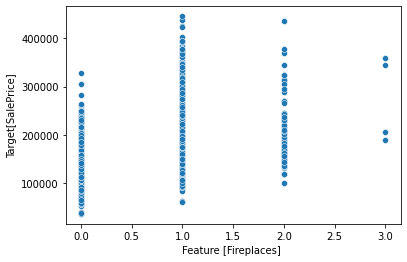

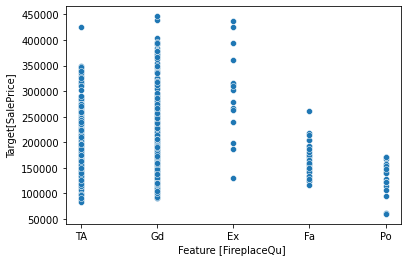

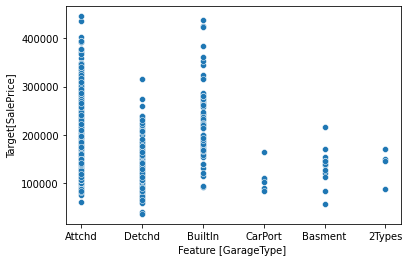

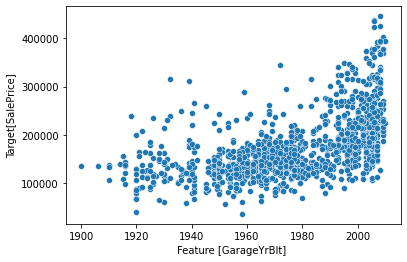

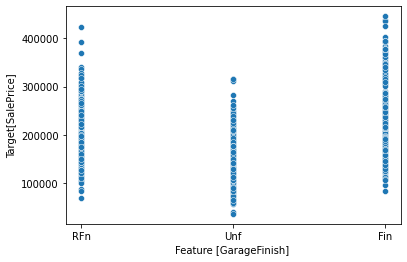

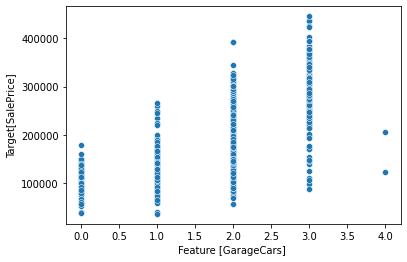

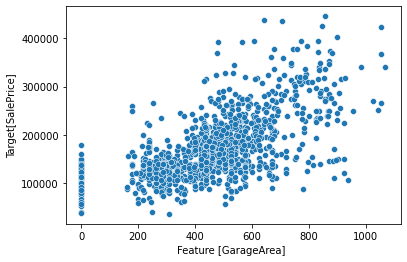

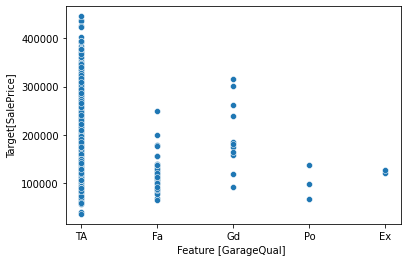

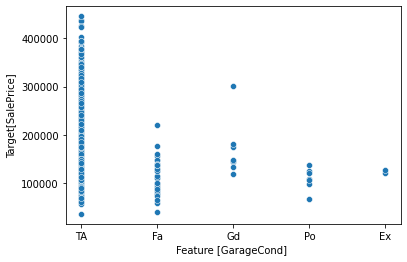

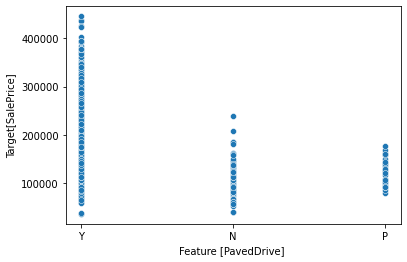

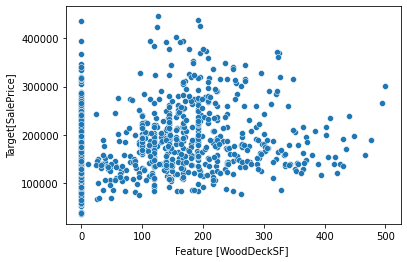

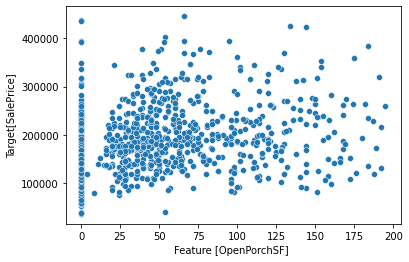

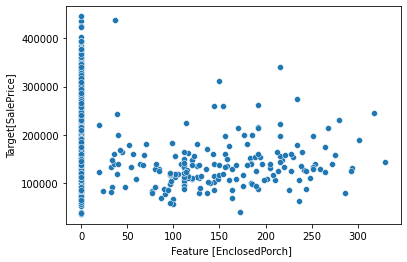

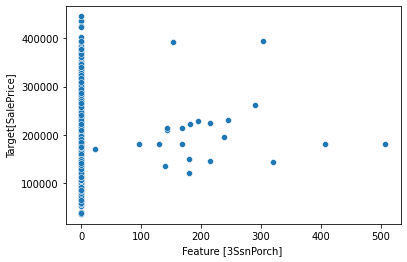

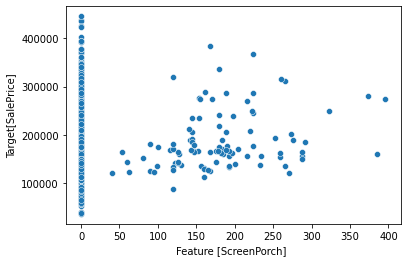

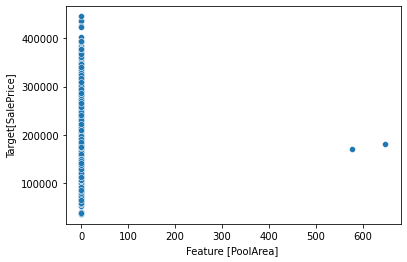

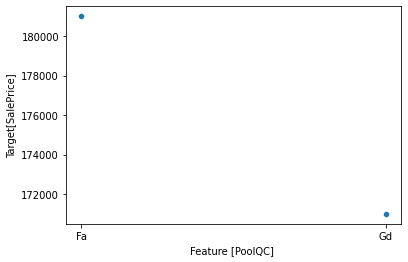

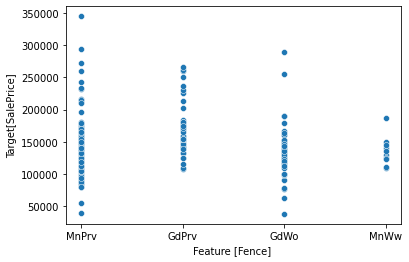

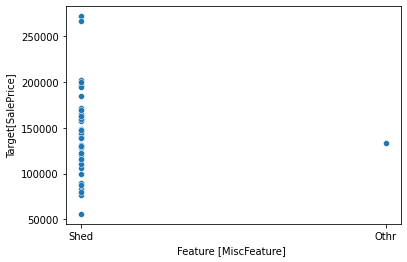

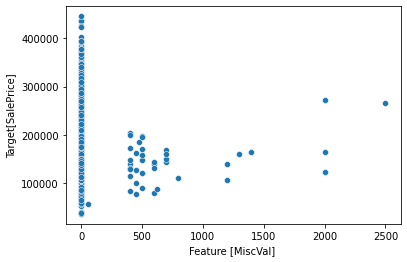

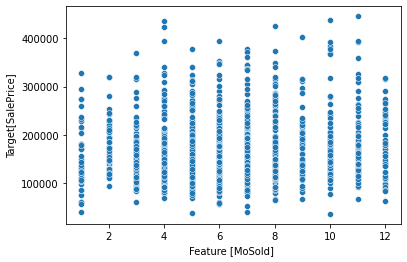

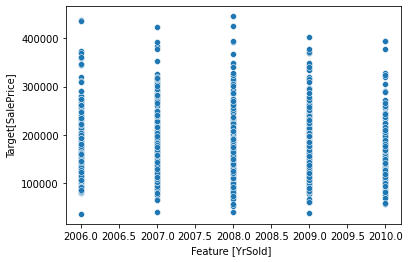

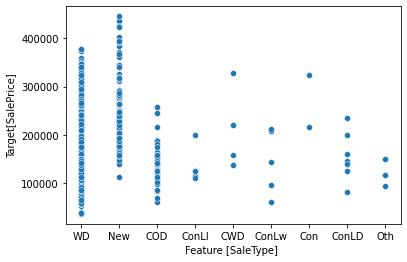

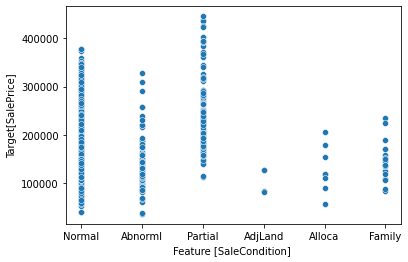

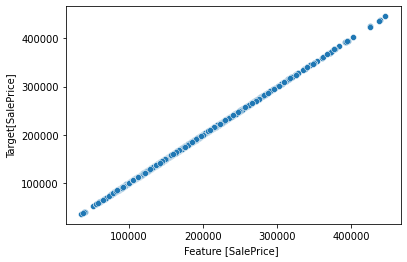

['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']
(1273, 80)


In [ ]:
for i in col_name:
  fig,ax = plt.subplots()
  sns.scatterplot(x=i,y='SalePrice',data=train_df)
  ax.set_ylabel('Target[SalePrice]')
  ax.set_xlabel('Feature [' + str(i) + '] ')
plt.show()
print(cor_list)
print(train_df.shape) 

In [ ]:
print(train_df.shape)

(1273, 80)


### Transform ข้อมูล 
#### เปลี่ยนข้อมูล Saleprice จากรูปแบบที่มีการเบ้ขวา โดยใช้วิธี log
##### อ้างอิงจากบทความ https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55


 mu = 170839.84 and sigma = 64988.01



/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


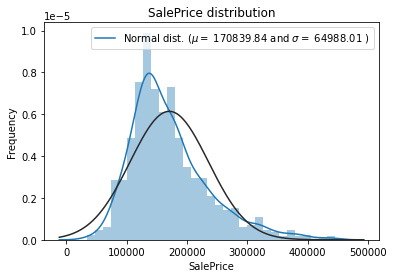

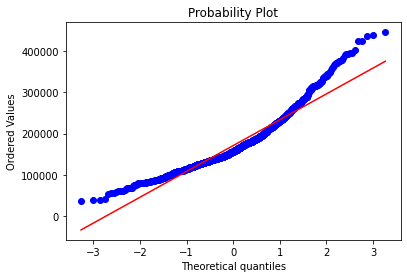

In [ ]:
### พล็อตข้อมูลtarget เพื่อดูลักษณธของการกระจายตัว
sns.distplot(train_df['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 11.98 and sigma = 0.37



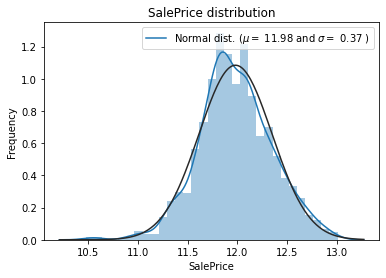

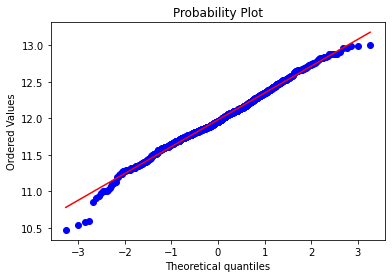

In [ ]:
###  Transform ข้อมูล โดยใช้ log(1+x)

train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

### พล็อตข้อมูลหลังการ Transform
sns.distplot(train_df['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

### fill missing data ต่างๆ

In [ ]:
### รวมข้อมูลส่วนของ train และ test เพื่อ ทำการแทนที่ค่าที่หายไป(fill missing value) และ Drop ข้อมูลบางcolumn 
## ที่ต้องรวมข้อมูลนั้นเนื่องมาจากต้องการให้ข้อมูลชุดtest และ train มีลักษณะที่เหมือนกัน
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df.SalePrice.values
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2732, 79)


In [ ]:
###  ทำการแทนที่ข้อมูลที่หายไป
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



In [ ]:
### เปลี่ยนแปลงข้อมูลที่เป็น category  แต่เก็บในรูปแบบการใช้เลข ให้เป็น string
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### เพิ่มข้อมูลจากข้อมูลที่มีอยู่

In [ ]:
### เพิ่มข้อมูลอื่นๆอ้างอิงมาจากข้อมูลที่มีอยู่
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

### Drop ข้อมูลที่ไม่มีประโยชน์

In [ ]:
### การdropอ้างอิงมาจาก scatterplot ด้านบน ซึ่งข้อมูลพวกนี้จะทำให้modelสับสน อาทิเช่น pool QC ที่มีข้อมูลของpool หลังการ clean แค่ 2 ค่า จึงไม่จำเป็นต้องมี
all_data = all_data.drop(['Utilities'], axis=1)
all_data = all_data.drop(['Street'], axis=1)
all_data = all_data.drop(['PoolQC'], axis=1)
all_data = all_data.drop(['PoolArea'], axis=1)
all_data = all_data.drop(['MiscFeature'], axis=1)


### transform data ที่อยู่ในรูป category ให้เป็นในรูปที่เหมาะสมเพื่อวิเคราะห์ต่อ โดยในที่นี้ใช้ LabelEncoder
#####(โดยผู้เขียนได้ทดลองกับการ encode แบบ onehot encoder แล้ว การใช้แบบ Label ได้ผลลัพธ์ที่ดีกว่าจึงคงใช้แบบนี้)

In [ ]:
### Transform ข้อมูลที่เป็น category ให้อยู่ลักษณะที่พร้อมใช้
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2732, 78)


### transform data ในส่วนของfeature ที่มีความเบ้ ผ่าน Boxcox transform

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,25.478215
LowQualFinSF,14.109556
3SsnPorch,11.312950
LandSlope,5.167841
KitchenAbvGr,4.327539
BsmtFinSF2,4.200387
EnclosedPorch,3.998627
BsmtHalfBath,3.972840
ScreenPorch,3.885473
LotArea,2.688720


In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    

There are 59 skewed numerical features to Box Cox transform


### เตรียมข้อมูลสำหรับการ train
###### (ก่อนหน้านี้ผู้เขียนได้ทำการทดลองโดยแบ่งข้อมูลของ train set ให้เป็นกลุ่มที่ใช้ train(train สำหรับ train และ validation) และ test(สำหรับไว้ test โดยเฉพาะไม่ใช่ข้อมูล test ที่ kaggle ให้) อย่างไรก็ตามเนื่องจากข้อมูลที่น้อยเกินไปจึงทำให้ผลลัพธ์ออกมามีค่าน้อยกว่าการ train โดยไม่แยกกลุ่ม) 

In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
train = all_data[:ntrain]
test = all_data[ntrain:]


(2732, 213)


# ส่วนที่ 3 Model prediction
#### ข้อมูลในส่วนนี้อ้างอิงมาจากบทความใน kaggle 

https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1

##### โดยนำโมเดลตัวอย่างจากสองโค้ดมาดัดแปลงเพื่อใช้ร่วมกัน

In [ ]:

#Validation function
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
def rmsle_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kfolds))
    return(rmse)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

lasso = make_pipeline(RobustScaler(),  LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))
ENet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =42, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_stk= StackingCVRegressor(regressors=(ridge, lasso, ENet, GBoost, model_xgb, model_lgb),
                                meta_regressor=model_xgb,
                                use_features_in_secondary=True)


###  cross validation ของ train set

In [ ]:
### เก็บค่า error_train เพื่อไปเช็คกับการปรับเปลี่ยนแบบอื่นๆ
errors_train = OrderedDict()
models =['lasso','ENet','KRR','GBoost','model_xgb','model_lgb','model_stk']
for model_name in models:
  errors_train[model_name] = []


In [ ]:
### cross validation 
score_lasso = rmsle_cv(lasso)
score_ENet = rmsle_cv(ENet)
score_KRR = rmsle_cv(KRR)
score_GBoost = rmsle_cv(GBoost)
score_xgb = rmsle_cv(model_xgb)
score_lgb = rmsle_cv(model_lgb)
score_stk = rmsle_cv(model_stk)

errors_train['lasso'].append(score_lasso.mean())
errors_train['ENet'].append(score_ENet.mean())
errors_train['KRR'].append(score_KRR.mean())
errors_train['GBoost'].append(score_GBoost.mean())
errors_train['model_xgb'].append(score_xgb.mean())
errors_train['model_lgb'].append(score_lgb.mean())
errors_train['model_stk'].append(score_stk.mean())

print("\nLasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))

print("ElasticNet score: {:.4f} ({:.4f})\n".format(score_ENet.mean(), score_ENet.std()))

print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score_KRR.mean(), score_KRR.std()))

print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score_GBoost.mean(), score_GBoost.std()))

print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgb.mean(), score_lgb.std()))
print("StackingRegressor score: {:.4f} ({:.4f})\n" .format(score_stk.mean(), score_stk.std()))



Lasso score: 0.1092 (0.0070)

ElasticNet score: 0.1092 (0.0070)

Kernel Ridge score: 0.1132 (0.0088)

Gradient Boosting score: 0.1144 (0.0115)

Xgboost score: 0.1157 (0.0092)

LGBM score: 0.1140 (0.0106)

StackingRegressor score: 0.1095 (0.0113)



### Fit train set กับ โมเดล เพื่อใช้ในการ predict

In [ ]:
lasso.fit(train.values,y_train)
ENet.fit(train.values,y_train)
KRR.fit(train.values,y_train)
GBoost.fit(train.values,y_train)
model_lgb.fit(train.values,y_train)
model_xgb.fit(train.values,y_train)
model_stk.fit(train.values,y_train)

StackingCVRegressor(meta_regressor=XGBRegressor(colsample_bytree=0.4603,
                                                gamma=0.0468,
                                                learning_rate=0.05,
                                                min_child_weight=1.7817,
                                                n_estimators=2200, nthread=-1,
                                                random_state=42,
                                                reg_alpha=0.464,
                                                reg_lambda=0.8571, silent=1,
                                                subsample=0.5213),
                    regressors=(Pipeline(steps=[('robustscaler',
                                                 RobustScaler()),
                                                ('ridgecv',
                                                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14....
                                             random_state=42, reg_alpha=0.464,

### หา rootmeansqure error ผลลัพธ์ ของ train set กับ คำตอบที่รู้อยู่แล้ว เพื่อหาสัดส่วนเพื่อใช้ในการรวมคำตอบในแต่ละโมเดล 

In [ ]:
rmse_arr= []
Y_predicted=  lasso.predict(train.values)
rmse_arr.append(rmsle(y_train,Y_predicted))
Y_predicted=  ENet.predict(train.values)
rmse_arr.append(rmsle(y_train,Y_predicted))
Y_predicted=  KRR.predict(train.values)
rmse_arr.append(rmsle(y_train,Y_predicted))
Y_predicted=  GBoost.predict(train.values)
rmse_arr.append(rmsle(y_train,Y_predicted))
Y_predicted=  model_lgb.predict(train.values)
rmse_arr.append(rmsle(y_train,Y_predicted))
Y_predicted=  model_xgb.predict(train.values)
rmse_arr.append(rmsle(y_train,Y_predicted))
Y_predicted=  model_stk.predict(train.values)
rmse_arr.append(rmsle(y_train,Y_predicted))

##### สัดส่วนของ Blendmodel อ้างอิงมาจากค่า rmse หาก rmse น้อย จะมีน้ำหนักมาก

In [ ]:
def blend_models_predict(X,rmse_list):
  rmse_arr=np.array(rmse_list)
  rmse_arr_inv= (sum(rmse_arr)/rmse_arr)
  rmse_arr_ratio = rmse_arr_inv/sum(rmse_arr_inv)
  return ((rmse_arr_ratio[0]  * lasso.predict(X)) + \
            (rmse_arr_ratio[1]  * ENet.predict(X)) + \
            (rmse_arr_ratio[2] * KRR.predict(X)) + \
            (rmse_arr_ratio[3] * GBoost.predict(X)) + \
            (rmse_arr_ratio[4] * model_lgb.predict(X)) + \
            (rmse_arr_ratio[5] * model_xgb.predict(X)) + \
            (rmse_arr_ratio[6] * model_stk.predict(np.array(X))))

##### RMSE ของข้อมูล predict

In [ ]:

Y_predicted=  blend_models_predict(train.values,rmse_arr)
print(rmsle(y_train,Y_predicted))

0.06570586212283412


##### ทำการpredict ข้อมูลชุด test

In [ ]:
Y_predicted= blend_models_predict(test.values,rmse_arr)
y_pred = np.expm1(Y_predicted)
print(y_pred)

[123161.70438806 165212.48563834 185177.75448014 ... 160114.11557941
 117175.18462616 222506.45263666]


##### เก็บข้อมูลสำหรับการเปรียบเทียบ

In [ ]:
errors_train_df = pd.DataFrame(errors_train)
errors_train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/ML1/train_result/errors_train_best_1percent.csv')

# ส่งคำตอบ

In [ ]:
y_pred_df = pd.DataFrame(y_pred,index=test_ID,columns=['SalePrice'])
y_pred_df.to_csv('/content/drive/MyDrive/Colab Notebooks/ML1/train_result/sol/ans_best_1percent_blend_repercent_test.csv')